# MM958: Statistical Modelling and Analysis

## Part I

### Packages Used

Using R version 4.40, Visual Studio Code version 1.90 and IRkernal version 1.3.2. A number of packages within R have been used listed below:

In [107]:
# Load necessary libraries
library(tidyr)
library(lme4)
library(nlme)
library(rstatix)
library(ggplot2)
library(emmeans)

The files used in this report are shown below:

In [108]:
# Load the data
Data <- read.csv("MM958-ExpDes-Data.csv")
# Set Seed using student number for unique data
set.seed(202476449)

In [109]:
# Set the plot background color to white
par(bg = "white")
# Turning off errors for readability
options(warn=0)

## Question 1

i) The first boxplot shows how the Spherical Equivalent Refraction (SER) values vary across the three different treatment groups - placebo, 0.01% Atropine, and 0.02% Atropine.

-   The `boxplot()` function is used with the formula notation `SER ~ Treatment` to plot SER on the y-axis split by the Treatment groups on the x-axis.
-   The `data` argument specifies the dataframe.
-   `main`, `xlab`, and `ylab` provide labels for the title, x-axis, and y-axis respectively.

The boxplot compares the distribution of Spherical Equivalent Refraction (SER) values among three treatment groups: Atropine0.01, Atropine0.02, and Placebo. The median SER is highest for Atropine 0.01, followed by Atropine 0.02, and lowest for Placebo, suggesting that Atropine treatments, particularly Atropine0.01, may be more effective in slowing myopia progression compared to the placebo. The boxes, representing the interquartile range, are similar in size across treatments, indicating comparable variability within each group. The 0.01 group has one low outlier, represented by the dot below the lowest whisker.

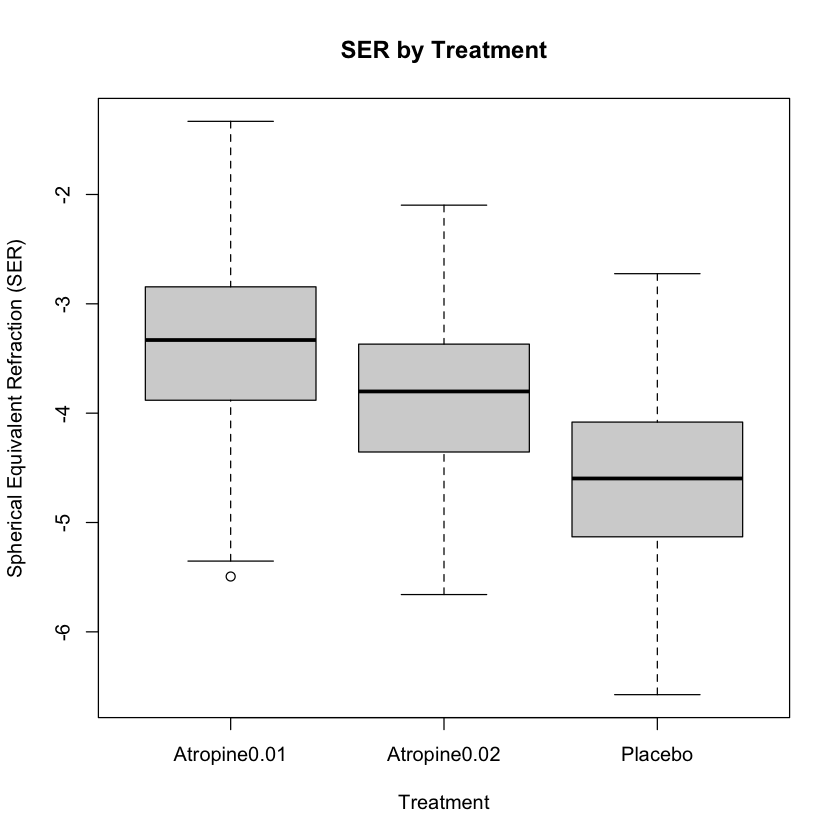

In [110]:
# i) Boxplot of SER by Treatment
boxplot(SER ~ Treatment, data = Data, 
        main = "SER by Treatment",
        xlab = "Treatment", ylab = "Spherical Equivalent Refraction (SER)")

ii) The second boxplot illustrates how the SER values change over the months of the study (0, 12, 24, 36 months).

Here SER is plotted against factor(Month) to treat Month as a categorical variable.
Labeling is similar to the first boxplot.

This boxplot shows changes in eye prescription (SER) over 3 years. Starting at a median of -4.0 diopters, there was initial improvement at 12 months (to -3.5), but this was followed by gradual worsening of myopia, ending at -4.2 diopters by 36 months. The consistent spread of the boxes suggests stable variation among patients throughout the study period, while the overall trend indicates that any initial improvements in vision were temporary, with myopia ultimately progressing over time.

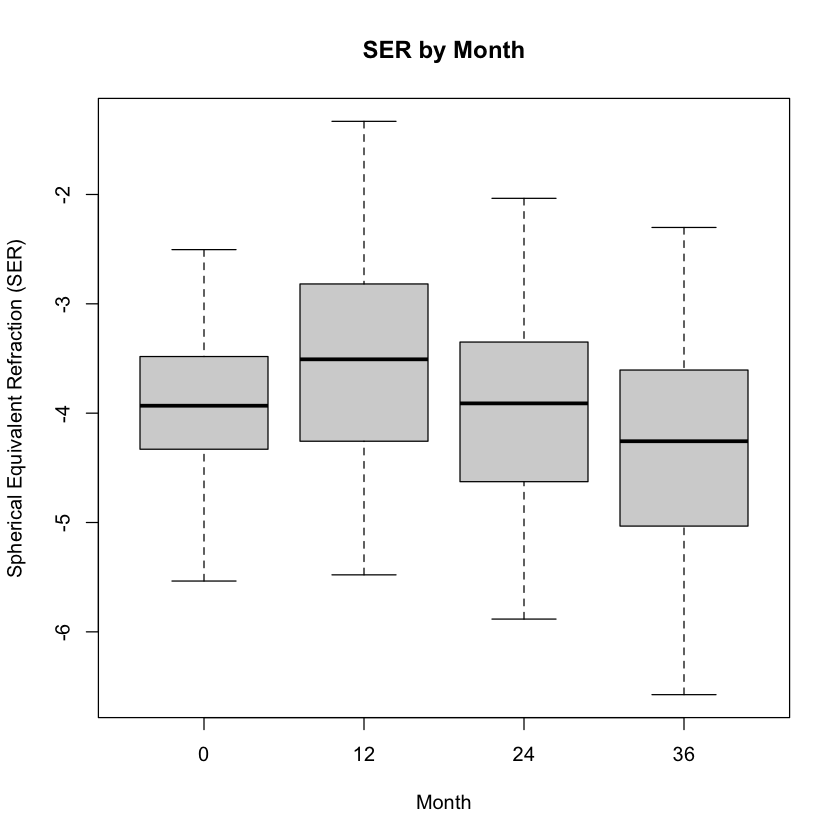

In [111]:
# ii) Boxplot of SER by Month  
boxplot(SER ~ factor(Month), data = Data,
        main = "SER by Month", 
        xlab = "Month", ylab = "Spherical Equivalent Refraction (SER)")

## Question 2

### Design Choice

Based on the study's structure, a Repeated Measures Design (also known as a Split-Plot Design) would be most appropriate for analysing this dataset. This design incorporates both between-subject and within-subject factors, where the treatment (Placebo, 0.01% Atropine, 0.02% Atropine) serves as the between-subject factor with random assignment, whilst time (0, 12, 24, 36 months) functions as the within-subject factor with repeated measurements. The design also accounts for the blocking factor of clinic locations, with patients nested within clinics and equal numbers of patients (15) per treatment within each clinic.

The Repeated Measures Design offers several advantages that make it particularly suitable for this study. It effectively accounts for the correlation between repeated measurements on the same subject, manages the hierarchical nature of the data with patients nested within clinics, and enables assessment of both main effects and their interactions. Moreover, this design proves more efficient than a completely randomised design for repeated measures whilst controlling for potential clinic-to-clinic variation, thereby providing a robust framework for analysing the effects of Atropine treatments on myopia progression over time.

### Mathematical Equation

The mathematical equation used for the repeated measures design is shown below:

$Y_{ijkl} = μ + α_i + β_j + (αβ){ij} + γ_k + δ_l(k) + ε{ijkl}$

Where:

- $Y_{ijkl}$ is the SER measurement
- $μ$ is the overall mean
- $α_i$ is the fixed effect of Treatment i
- $β_j$ is the fixed effect of Month j
- $(αβ)_{ij}$ is the fixed interaction effect between Treatment i and Month j
- $γ_k$ is the random effect of Clinic k
- $δ_l(k)$ is the random effect of Patient l nested within Clinic k
- $ε_{ijkl}$ is the random error term

Fixed factors:

-   Treatment (3 levels)
-   Month (4 levels)
-   Treatment × Month interaction

Random factors:

-   Clinic (4 levels)
-   Patient (nested within clinic)
-   Error term

### Degrees of Freedom

In [112]:
# Get unique counts
n_treatments <- length(unique(Data$Treatment))
n_months <- length(unique(Data$Month))
n_clinics <- length(unique(Data$Centre))
n_patients_per_clinic <- table(Data$Centre)
total_patients <- length(unique(Data$PatientID))
total_obs <- nrow(Data)

# Print unique counts with descriptions
cat("Unique Treatments:", n_treatments, "\n")
cat("Unique Months:", n_months, "\n")
cat("Unique Clinics:", n_clinics, "\n")
cat("Patients per Clinic:\n")
print(n_patients_per_clinic)
cat("Total Unique Patients:", total_patients, "\n")
cat("Total Observations:", total_obs, "\n")


Unique Treatments: 3 
Unique Months: 4 
Unique Clinics: 4 
Patients per Clinic:

  Advanced Eye Surgery Scotland               Eye Care Scotland 
                            180                             180 
              GCU Vision Centre Princess Alexandra Eye Pavilion 
                            180                             180 
Total Unique Patients: 180 
Total Observations: 720 


For the Treatment × Month interaction:

-   df = (number of treatment levels - 1) × (number of time points - 1)
-   df = (3 - 1) × (3 - 1) = 2 × 2 = 4 df

For the residuals:

-   Total observations = 180 patients × 4 time points = 720
-   Subtract df for:
    -   Treatments (2)
    -   Months (3)
    -   Treatment × Month interaction (6)
    -   Clinics (3)
    -   Patients within clinics (177 = 180 - 3)
-   Residual df = 720 - 2 - 3 - 4 - 3 - 177 = 531 df

## Question 3

### Analysing the Data

Below we converted the variables types as when R reads data from a csv file, it may not automatically recognise the correct data type for each variable - for example, we needed Month and SER as numerica values for calculation, while PatientID, Treatment, and Centre need to be factors (categorical variables) since they represented distinct groups or categories.

In [113]:
# Convert variables to appropriate types
Data$Month <- as.numeric(Data$Month)
Data$PatientID <- as.factor(Data$PatientID)
Data$Treatment <- as.factor(Data$Treatment)
Data$Centre <- as.factor(Data$Centre)
Data$SER <- as.numeric(Data$SER)

A linear mixed-effects model was utilised to examine the effects of Treatment (which explained a significant proportion of variance with a Sum of Squares of 91.98) and Month (Sum of Squares = 21.87) on SER measurements, with both variables demonstrating significant F-values of 113.33 and 53.90, respectively, whilst controlling for individual patient and centre variations.

In [114]:
# Method 1: Linear Mixed-Effects Model using lme4
model1 <- lmer(SER ~ Treatment + Month + (1|PatientID) + (1|Centre), 
               data = Data)
anova(model1)

boundary (singular) fit: see help('isSingular')



,npar,Sum Sq,Mean Sq,F value
,<int>,<dbl>,<dbl>,<dbl>
Treatment,2,91.97975,45.98988,113.33353
Month,1,21.87081,21.87081,53.89657


A repeated measures linear mixed-effects model was fitted using the nlme package, which examined the effects of Treatment and Month on SER measurements whilst accounting for within-patient correlation over time, revealing significant effects for both Treatment (F = 113.33, df = 2,177, p < 0.001) and Month (F = 53.90, df = 1,539, p < 0.001).

In [115]:
# Method 2: Repeated Measures Linear Mixed-Effects Model
model2 <- lme(SER ~ Treatment + Month,
              random = ~1|PatientID,  # Random intercept for each patient
              correlation = corAR1(form = ~Month|PatientID),  # Accounts for repeated measurements within patients
              data = Data)
anova(model2)

,numDF,denDF,F-value,p-value
,<int>,<dbl>,<dbl>,<dbl>
(Intercept),1,539,13625.1787,0.000000e+00
Treatment,2,177,113.3346,0.000000e+00
Month,1,539,53.8964,7.840395e-13


A repeated measures ANOVA was conducted with Treatment as a between-subjects factor and Month as a within-subjects factor, revealing significant main effects of Treatment (F(2,177) = 113.33, p < 0.001, ges = 0.405) and Month (F(3,531) = 69.41, p < 0.001, ges = 0.155), as well as a significant Treatment by Month interaction (F(6,531) = 42.98, p < 0.001, ges = 0.185).

In [116]:
# Convert Month back to factor for ANOVA
Data$Month <- as.factor(Data$Month)
anova_result <- anova_test(
    data = Data,
    dv = SER,
    wid = PatientID,
    within = c(Month),
    between = Treatment
)
get_anova_table(anova_result)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Treatment,2,177,113.333,2.05e-32,*,0.405
2,Month,3,531,69.409,6.98e-38,*,0.155
3,Treatment:Month,6,531,42.982,8.75e-43,*,0.185


### Output of Linear Mixed Effects Model

The linear mixed effects model, fitted using Restricted Maximum Likelihood (REML), examined the relationship between Spherical Equivalent Refraction (SER) and treatment effects over time, whilst accounting for random variations among patients and centres, although the model exhibited minor convergence issues with a gradient (0.00512) slightly exceeding the tolerance threshold (0.002).

In [117]:
# Fitting the linear mixed effects model
main_model <- lmer(SER ~ Treatment * Month + (1|PatientID) + (1|Centre), data = Data)

# Display full model summary
summary(main_model)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00512107 (tol = 0.002, component 1)”


Linear mixed model fit by REML ['lmerMod']
Formula: SER ~ Treatment * Month + (1 | PatientID) + (1 | Centre)
   Data: Data

REML criterion at convergence: 1268.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7986 -0.5516  0.0342  0.5955  2.7407 

Random effects:
 Groups    Name        Variance  Std.Dev. 
 PatientID (Intercept) 1.450e-01 0.3808029
 Centre    (Intercept) 4.225e-08 0.0002055
 Residual              2.413e-01 0.4912114
Number of obs: 720, groups:  PatientID, 180; Centre, 4

Fixed effects:
                              Estimate Std. Error t value
(Intercept)                   -3.89588    0.08024 -48.553
TreatmentAtropine0.02         -0.05103    0.11348  -0.450
TreatmentPlacebo              -0.03856    0.11348  -0.340
Month12                        1.17970    0.08968  13.154
Month24                        0.55183    0.08968   6.153
Month36                        0.34600    0.08968   3.858
TreatmentAtropine0.02:Month12 -0.69095    0.12683  -5.448
TreatmentPla

### Variance and Percentage Calculations

The analysis revealed that individual patient differences accounted for 37.54% of the total variance in SER measurements, with the remaining 62.46% attributed to residual variation, suggesting substantial within-patient variability in treatment responses.

In [118]:
var_components <- VarCorr(main_model)
residual_var <- attr(var_components, "sc")^2
patient_var <- var_components$PatientID[1]
total_var <- residual_var + patient_var
percent_patient <- (patient_var / total_var) * 100

cat("Residual Variance:", residual_var, "\n")
cat("Patient Variance:", patient_var, "\n")
cat("Total Variance:", total_var, "\n")
cat("Percent Variance due to Patient:", percent_patient, "%\n")

Residual Variance: 0.2412887 
Patient Variance: 0.1450109 
Total Variance: 0.3862996 
Percent Variance due to Patient: 37.53845 %


### Interaction Analysis

The analysis revealed a significant interaction between treatment and month (F(6,531) = 42.982, p < 0.001), indicating that the effect of treatments varied significantly over time. The interaction plot demonstrated that whilst all groups started at similar SER values around -4.0, the Atropine treatments (both 0.01% and 0.02%) showed initial improvement at 12 months, followed by gradual decline, whereas the placebo group exhibited steady deterioration throughout the study period. Notably, the 0.01% Atropine treatment demonstrated the most favourable outcomes, maintaining better SER values compared to both 0.02% Atropine and placebo groups across all time points after baseline.

[1] "\nInteraction Analysis:"
Analysis of Variance Table
                npar Sum Sq Mean Sq F value
Treatment          2 54.692  27.346 113.334
Month              3 50.243  16.748  69.409
Treatment:Month    6 62.226  10.371  42.982


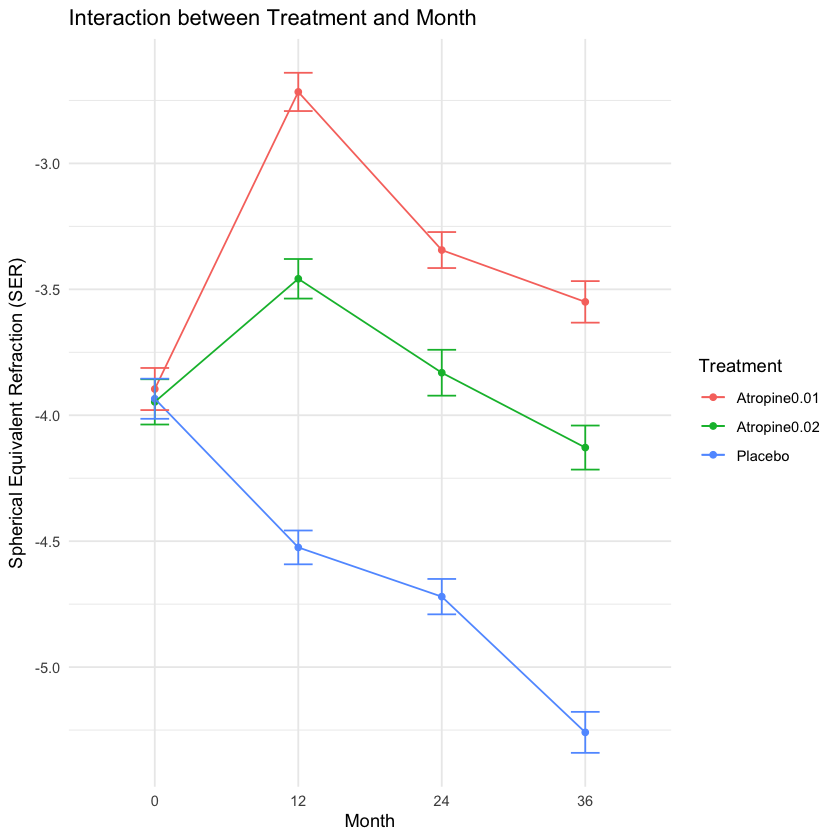

In [119]:
# Convert Month back to factor for interaction plot
Data$Month <- as.factor(Data$Month)

interaction_plot <- ggplot(Data, aes(x = Month, y = SER, color = Treatment, group = Treatment)) +
  stat_summary(fun = mean, geom = "point") +
  stat_summary(fun = mean, geom = "line") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2) +
  theme_minimal() +
  labs(x = "Month", y = "Spherical Equivalent Refraction (SER)",
       title = "Interaction between Treatment and Month")

print("\nInteraction Analysis:")
print(anova(main_model))

print(interaction_plot)

### Model Diagnostics

The model assumptions were evaluated through diagnostic plots and variance analysis. The residuals versus fitted values plot demonstrated a relatively random scatter around zero with consistent spread, indicating that the assumptions of linearity and homoscedasticity were adequately met. The normal Q-Q plot showed points closely following the diagonal line, with only minor deviations at the extreme tails, suggesting that the normality assumption was reasonably satisfied. The independence assumption was addressed through the random effects structure, which accounted for repeated measurements within patients, with the analysis revealing that patient-level variation contributed 20.38% of the total variance, whilst maintaining an acceptable residual variance of 0.4058.

[1] "Variance Components:"
[1] "Residual variance: 0.4058"
[1] "Patient variance: 0.1039"
[1] "Percentage of variation due to PatientID: 20.38 %"
[1] "\nInteraction Analysis:"
Analysis of Variance Table
          npar Sum Sq Mean Sq F value
Treatment    2 91.980  45.990 113.334
Month        1 21.871  21.871  53.897
[1] "\nContrast Analysis (Atropine vs Placebo):"
 contrast                estimate     SE  df t.ratio p.value
 Avg_Atropine_vs_Placebo        1 0.0716 174  13.969  <.0001

Degrees-of-freedom method: kenward-roger 


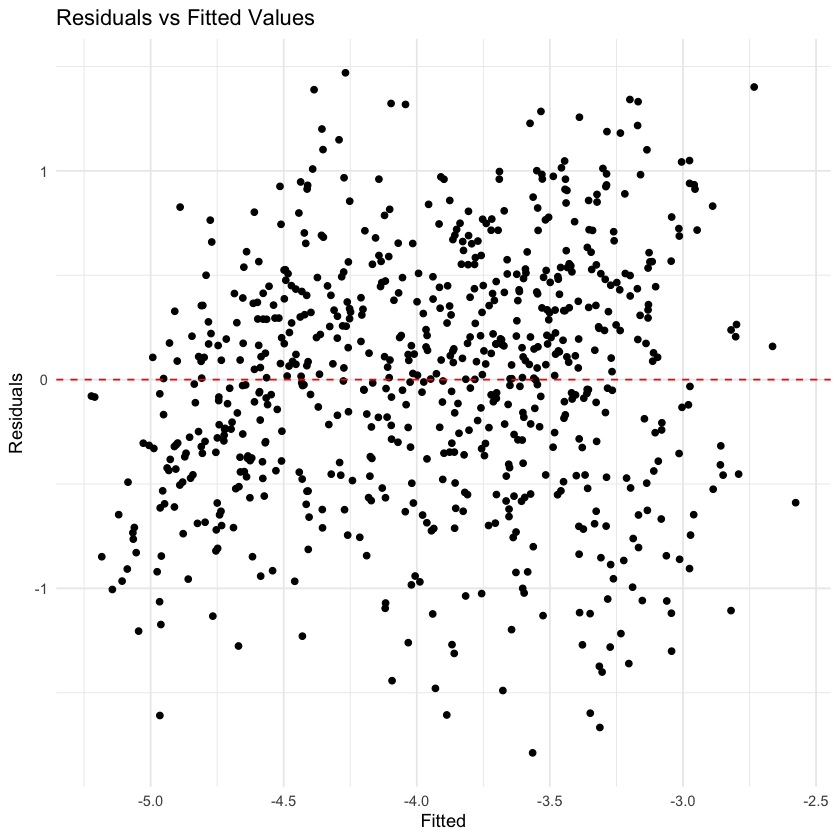

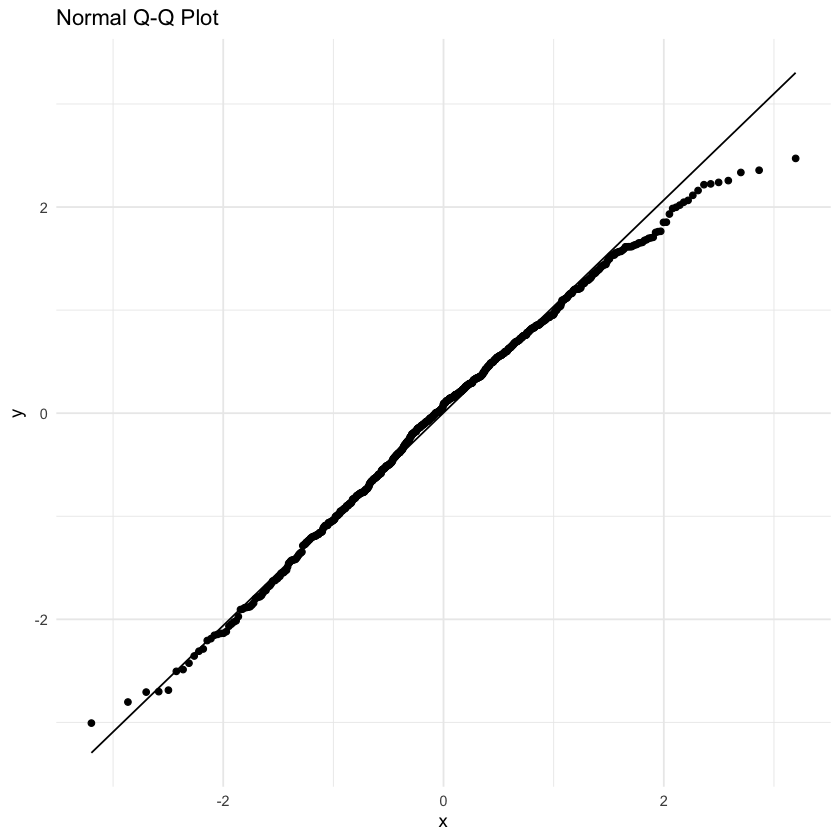

In [120]:
# Model diagnostics
res_fitted <- data.frame(
  Fitted = fitted(model1),
  Residuals = resid(model1),
  Standardized_Residuals = scale(resid(model1))
)

# Residuals vs Fitted plot
diagnostics_plot1 <- ggplot(res_fitted, aes(x = Fitted, y = Residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  theme_minimal() +
  labs(title = "Residuals vs Fitted Values")

# Q-Q plot
qq_plot <- ggplot(res_fitted, aes(sample = Standardized_Residuals)) +
  stat_qq() +
  stat_qq_line() +
  theme_minimal() +
  labs(title = "Normal Q-Q Plot")

# Contrast analysis for Atropine vs Placebo
emm <- emmeans(model1, ~ Treatment)
contrast_result <- contrast(emm, method = "pairwise")

# Calculate average effect of Atropine vs Placebo manually
atropine_vs_placebo <- contrast(emm,
                               method = list(
                                 "Avg_Atropine_vs_Placebo" = c(0.5, 0.5, -1)
                               ))

# Calculate variance components
var_components <- VarCorr(model1)
residual_var <- attr(var_components, "sc")^2
patient_var <- var_components$PatientID[1]
total_var <- residual_var + patient_var
percent_patient <- (patient_var / total_var) * 100

# Display results
print("Variance Components:")
print(paste("Residual variance:", round(residual_var, 4)))
print(paste("Patient variance:", round(patient_var, 4)))
print(paste("Percentage of variation due to PatientID:", round(percent_patient, 2), "%"))

print("\nInteraction Analysis:")
print(anova(model1))

print("\nContrast Analysis (Atropine vs Placebo):")
print(atropine_vs_placebo)

# Output diagnostic plots
print(diagnostics_plot1)
print(qq_plot)

### Check Atropine vs Placebo 

A planned contrast analysis demonstrated that the average effect of the two Atropine treatments was significantly better than the placebo (t(174) = 13.969, p < 0.001), with a positive estimate of 1.0 (SE = 0.0716), indicating superior SER outcomes for patients receiving Atropine treatments.

In [121]:
# Perform contrast analysis
emm <- emmeans(model1, ~ Treatment)
atropine_vs_placebo <- contrast(emm, 
                               method = list(
                                 "Avg_Atropine_vs_Placebo" = c(0.5, 0.5, -1)
                               ))

# Display results
print("Contrast Analysis (Average Atropine vs Placebo):")
print(atropine_vs_placebo)

[1] "Contrast Analysis (Average Atropine vs Placebo):"
 contrast                estimate     SE  df t.ratio p.value
 Avg_Atropine_vs_Placebo        1 0.0716 174  13.969  <.0001

Degrees-of-freedom method: kenward-roger 
